In [1]:
from adversary.core.noise_generators import AdditiveNoiseGenerator
from adversary.attacks.whitebox import TargetedWhiteBoxAttack, NonTargetedWhiteBoxAttack
from adversary.core.preprocessing import PreprocessingFromFunction
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image

from adversary.core.tensor_ops import TensorOps

In [2]:
model = InceptionV3(weights='imagenet')

def preprocess(x, input):
    input = tf.cast(input, dtype=tf.float32)
    if len(input.shape) == 2:
        input = tf.expand_dims(input, axis=-1)
        input = tf.image.grayscale_to_rgb(input)

    elif len(input.shape) == 3 and input.shape[-1] == 1:
        input = tf.image.grayscale_to_rgb(input)

    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    resized_image = tf.image.resize(input_tensor, (299, 299))
    batch_image = tf.expand_dims(resized_image, axis=0)
    return preprocess_input(batch_image)

    
pp = PreprocessingFromFunction.create(preprocess)

In [3]:
image = Image.open('panda.jpg')
image_array = np.array(image)

np.argmax(model.predict(pp.preprocess(image_array)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([388], dtype=int64)

In [6]:
attacker = TargetedWhiteBoxAttack(model, "cce", "adam", preprocessing=pp)
attacker = NonTargetedWhiteBoxAttack(model, "cce", "adam", preprocessing=pp)

In [7]:
noise = attacker.attack(image_array, target_class=20, epochs=200, strategy="spread")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
0.9181334
0.8922699
0.8569076
0.814401
0.7641564
0.71208054
0.65793097
0.6048746
0.54956436
0.50068927
0.45863688
0.4227616
0.39387596
0.37102684
0.35226655
0.3362628
0.32207033
0.30986485
0.2986721
0.28836036
0.27855983
0.26936728
0.26084152
0.25295162
0.24566719
0.2388595
0.23238066
0.22619759
0.22044088
0.21471588
0.2092307
0.20390965
0.19876684
0.1940211
0.18978019
0.18584341
0.18222587
0.1787697
0.17552133
0.17249998
0.16963781
0.16689895
0.16432688
0.16187383
0.15952837
0.15732892
0.15526764
0.15327504
0.15143427
0.14968555
0.14796083
0.1462998
0.14467388
0.14308958
0.14158863
0.14015159
0.13874301
0.13736194
0.13603917
0.13477647
0.13355748
0.13236508
0.13120012
0.13009273
0.12906308
0.12806311
0.12704995
0.12605567
0.12508799
0.12414716
0.12322025
0.12231514
0.121443756
0.12059437
0.11976689
0.11897499
0.11822148
0.11747349
0.11673806
0.11602975
0.115360476
0.11471773
0.114095375
0.11349545
0.11292397
0.11236235
0.111813545
0.111278325
0.11

In [6]:
np.argmax(model.predict(np.zeros(shape=[1, 229, 229, 3], dtype=np.float32)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([111], dtype=int64)

In [8]:
np.argmax(model.predict(attacker.noise_generator.apply_noise(pp.preprocess(image_array), noise)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


array([388], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


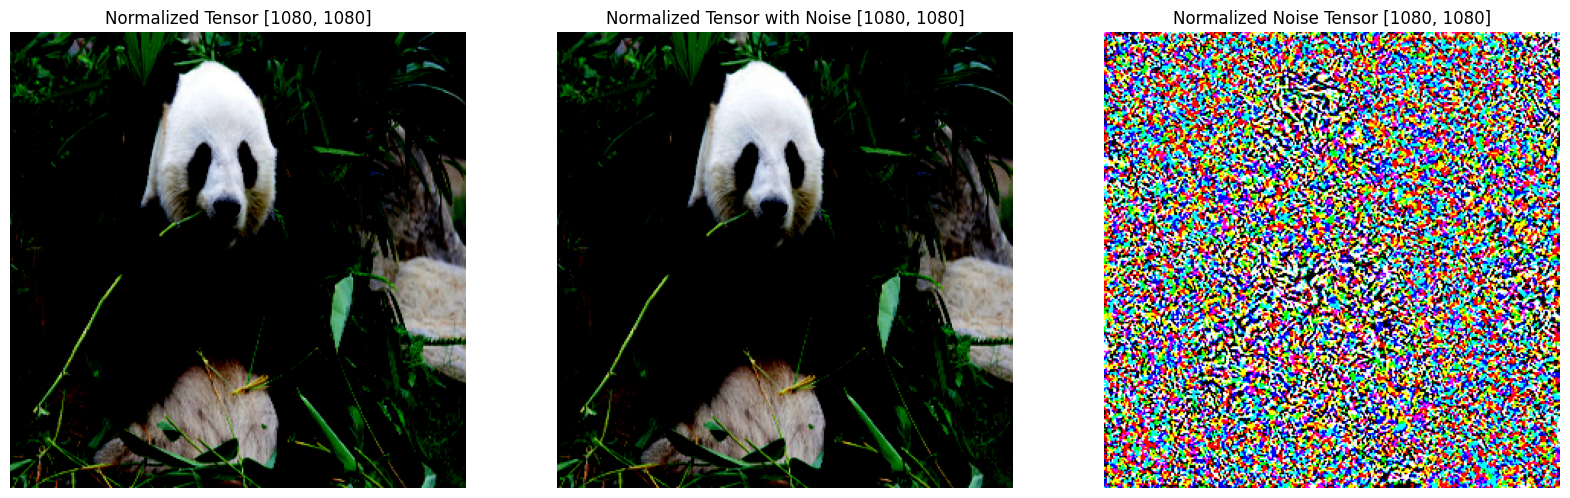

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

im1 = axes[0].imshow(pp.preprocess(image_array)[0])
axes[0].set_title('Normalized Tensor [1080, 1080]')
axes[0].axis('off')

im2 = axes[1].imshow(attacker.noise_generator.apply_noise(pp.preprocess(image_array), noise)[0])
axes[1].set_title('Normalized Tensor with Noise [1080, 1080]')
axes[1].axis('off')


normalized_noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))
im3 = axes[2].imshow(normalized_noise[0])
axes[2].set_title('Normalized Noise Tensor [1080, 1080]')
axes[2].axis('off')

plt.show()
